In [1]:
import ot
import torch

import torch.distributions as D
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils import data
from itertools import cycle
from tqdm.auto import trange

from hswfs.chswf import chswf
from hswfs.manifold.euclidean import Euclidean, Mahalanobis

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/clement/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## Data

In [3]:
n = 10000
d = 2

In [4]:
# Mixture

random_state = 42
torch.manual_seed(random_state)

d = 2
M = 5
l = 10

p = torch.ones(M)/M
mus = -l/2 + l * torch.rand((M,d), dtype=torch.float32, device=device)
sigmas = [torch.eye(d, device=device, dtype=torch.float32) for i in range(M)]

mix = D.Categorical(p.to(device))
comp = D.Independent(D.Normal(mus,torch.ones(M,2,device=device)),1)

gm = D.MixtureSameFamily(mix, comp)

X = gm.sample((n,))
ydata = torch.zeros(len(X))

train_dataset = data.TensorDataset(X, ydata)

rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=500, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

batch_data0 = next(dataiter)[0]

In [30]:
def _generate_data():
    """
        From https://github.com/pierreglaser/kale-flow
    """
    N, r, _delta = 80, 0.3, 0.5
    
    X = np.c_[r * np.cos(np.linspace(0, 2 * np.pi, N + 1)), r * np.sin(np.linspace(0, 2 * np.pi, N + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = np.r_[X, X[:N, :]-i*np.array([0, (2 + _delta) * r])]

    rs = np.random.RandomState(42)
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([r/np.sqrt(2), r/np.sqrt(2)])
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([0, r])

    Y = torch.from_numpy(Y).float()
    X = torch.from_numpy(X).float()
    Y.requires_grad = True
    return X, Y

In [36]:
X, Y = _generate_data()
X = np.concatenate([X[:,1][:,None], X[:,0][:,None]], axis=-1)

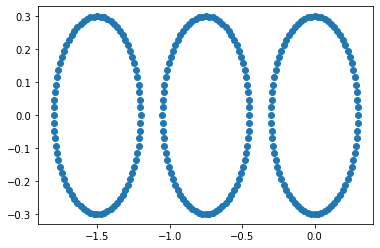

In [40]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [45]:
train_dataset = data.TensorDataset(torch.tensor(X), torch.zeros(len(X)))

rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=500, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

batch_data0 = next(dataiter)[0]

## SWF

In [71]:
d = 2
manifold = Euclidean(d)
# n = 500
n = X.shape[0]

# x0 = torch.randn(n, d, device=device)
x0 = torch.tensor(Y)

L = chswf(x0, 501, dataiter, manifold, tauk=1, n_projs=500)

/home/clement/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


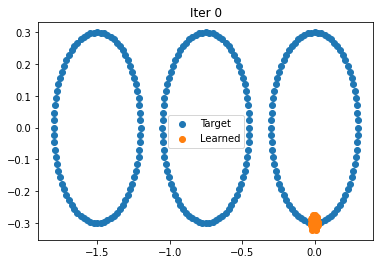

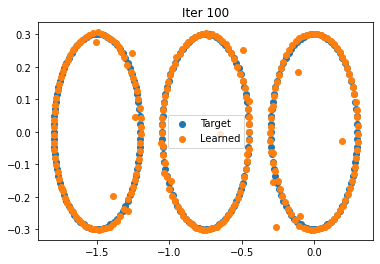

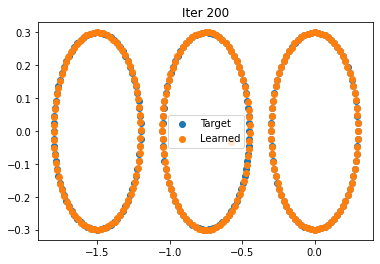

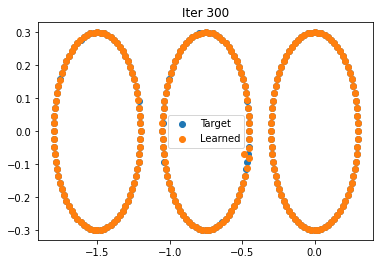

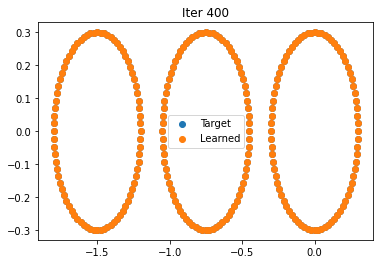

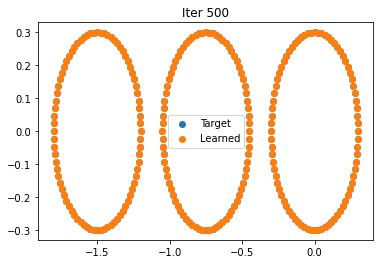

In [72]:
for k in range(0, 501, 100):
    target = next(dataiter)[0].detach()
    
    plt.scatter(target[:,0], target[:,1], label="Target")
    plt.scatter(L[k][:,0], L[k][:,1], label="Learned")
    plt.legend()
    plt.title("Iter "+str(k))
    plt.show()

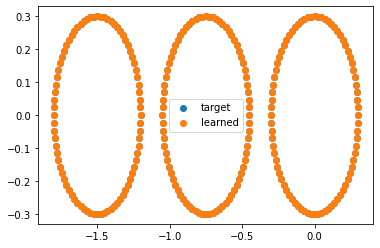

In [73]:
plt.scatter(X[:,0],X[:,1],label="target")
plt.scatter(L[-1][:,0],L[-1][:,1], label="learned")
plt.legend()
plt.show()

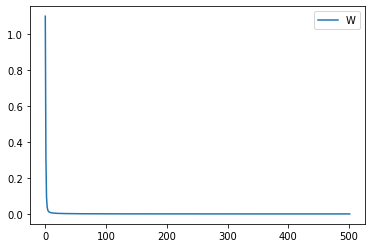

In [74]:
L_w = []

for x in L:
    target = next(dataiter)[0].detach().to(device)
    
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    M = ot.dist(x, target, metric="sqeuclidean")
        
    w = ot.emd2(a, b, M)
    L_w.append(w.item())


plt.plot(L_w, label="W")
plt.legend()
plt.show()

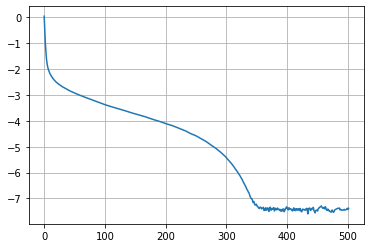

In [75]:
plt.plot(np.log10(np.array(L_w)))
plt.grid(True)
plt.show()

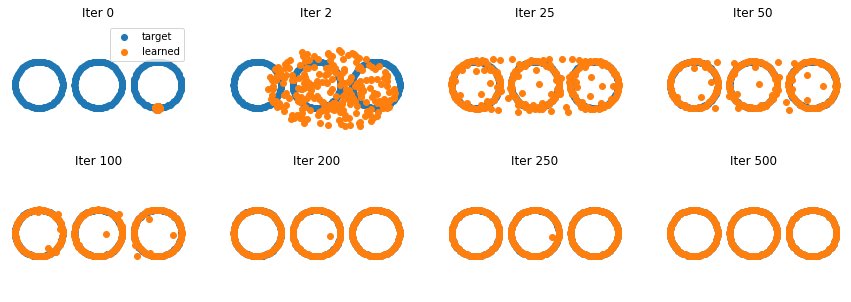

In [76]:
f, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))

for i, k in enumerate([0, 2, 25, 50]):
    axs[0, i].scatter(X[:,0],X[:,1],label="target")
    axs[0, i].scatter(L[k][:,0],L[k][:,1], label="learned")
    axs[0, i].set_title("Iter "+str(k))
    axs[0, i].axis("off")
    axs[0, i].set_xlim([-1.9, 0.4])
    axs[0, i].set_ylim([-0.8, 0.8])
    
for i, k in enumerate([100, 200, 250, 500]):
    axs[1, i].scatter(X[:,0],X[:,1],label="target")
    axs[1, i].scatter(L[k][:,0],L[k][:,1], label="learned")
    axs[1, i].set_title("Iter "+str(k))
    axs[1, i].axis("off")
    axs[1, i].set_xlim([-1.9, 0.4])
    axs[1, i].set_ylim([-0.8, 0.8])
    
axs[0, 0].legend()
plt.show()